## Definition of Lorenz model
The Lorenz system is:
$$ \dot{x} = \sigma (y-x) $$
$$ \dot{y} = x (\rho -z ) -y $$
$$ \dot{z} = xy -\beta z $$
In the cell below, it is coded in a class with default parameters $\sigma = 10$, $\rho = 28$, $\beta=8/3$, and initial condition $(1.5, -1.5, 20)$. 

In [47]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
class Lorenz():
    
    def __init__(self, nmembers = 1):
    
        self.nmembers = nmembers  # still don't understand what this is
        self.nx = 3         # number of variables

        # Parameters:
        self.sigma = 10
        self.rho = 28
        self.beta = 8./3.

        self.dt = 0.01 # timestep
        self.x0 = np.array([1.5, -1.5, 20.]) # Initial condition array
        self.xvar = self.initial_condition() # Reshapes our initial condition and does something else that I don't understand
        self.xvar_series = []  # This will be the array with the "solutions" (x,y,z) for each time step
        self.time = 0.         # Initial time count starts at zero
        self.time_series = []  # This will be the array with the time steps corresponding to the "solutions"

    def initial_condition(self):
        """Define the initial condition"""
         
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1)) #Reshapes x0
        else:
            p0 = 3.*np.eye(self.nx)                                             # what is this for? 
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
              
        return xout # This is the reshaped initial condition[[x0],[y0],[z0]]
    
    def rhs(self,x_in):
        """right hand side term of Lorenz 63. Gets a vector x,y,z and outputs a vector f(x,y,z)"""
        
        x_out = np.zeros_like(x_in)   # Creates array x_out of zeros with the shape of x_in
        x_out[0,] = self.sigma*(x_in[1,]-x_in[0,])               # Lorenz63 equation 1
        x_out[1,] = self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,] # Lorenz63 equation 2
        x_out[2,] = x_in[0,]*x_in[1,]-self.beta*x_in[2,]         # Lorenz63 equation 3
        
        return x_out
     
        
    def forward(self, nstep_in):
        '''This is RK2 (Heun's method) for Lorenz63'''
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        for it in range(nstep_in):
                self.xvar_series[:,it,:] = self.xvar   # Saves each solution vector to xvar_series to be plotted after
                self.time_series[it] = self.time       # Saves timestep respectively

                k1 = self.rhs(self.xvar)*self.dt
                xtmp = self.xvar + k1

                k2 = self.rhs(xtmp)*self.dt

                self.xvar += 0.5*(k1 + k2)    # RK2

                self.time += self.dt

                           
    def plot(self):
        plt.figure(figsize=(16,12))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=2.)
        plt.show()
    

## General set-up: length of integration
Number of time steps for all experiments:

In [49]:
ntime = 500

## Reference simulation
Run and plot a reference simulation. This simulation will serve as "truth" from which observations will extracted and assimilated. The graphs display the time evolution of $x$, $y$, $z$, respectively.

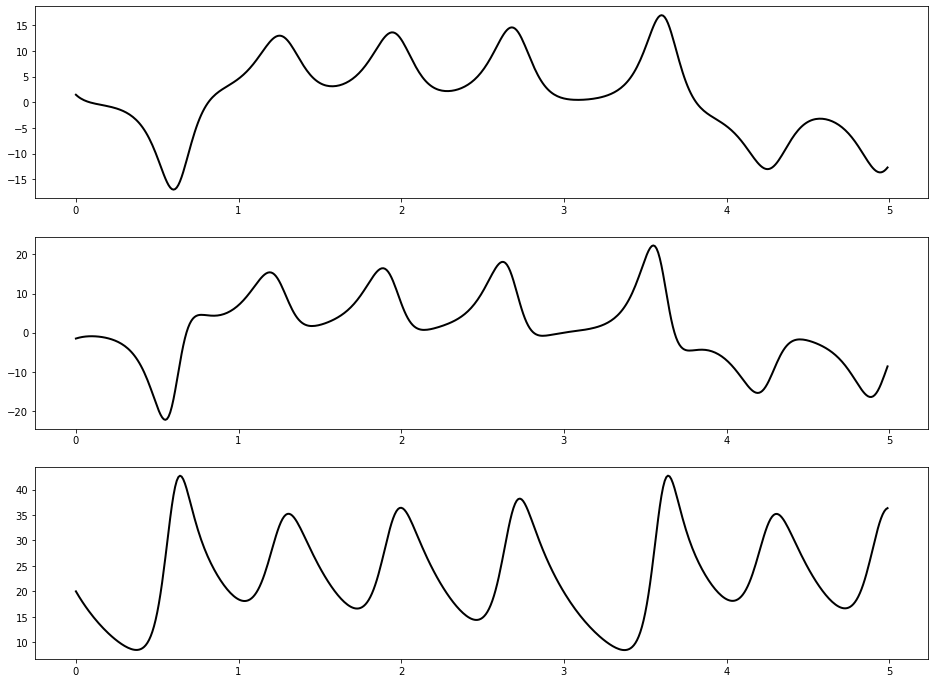

In [50]:
lorenz_ref = Lorenz()
lorenz_ref.forward(ntime)
lorenz_ref.plot()
true_state = lorenz_ref.xvar_series
true_time = lorenz_ref.time_series

## Lorenz model with inaccurate initial condition
We define a "wrong" initial state:

In [51]:
wrong_state = np.array([3., -3., 21.])

And we examine the consequences of initializing the model with this wrong state rather than the "true" one. On the graph, the reference simulation is in black, the one with the wrong initial condition is in red.

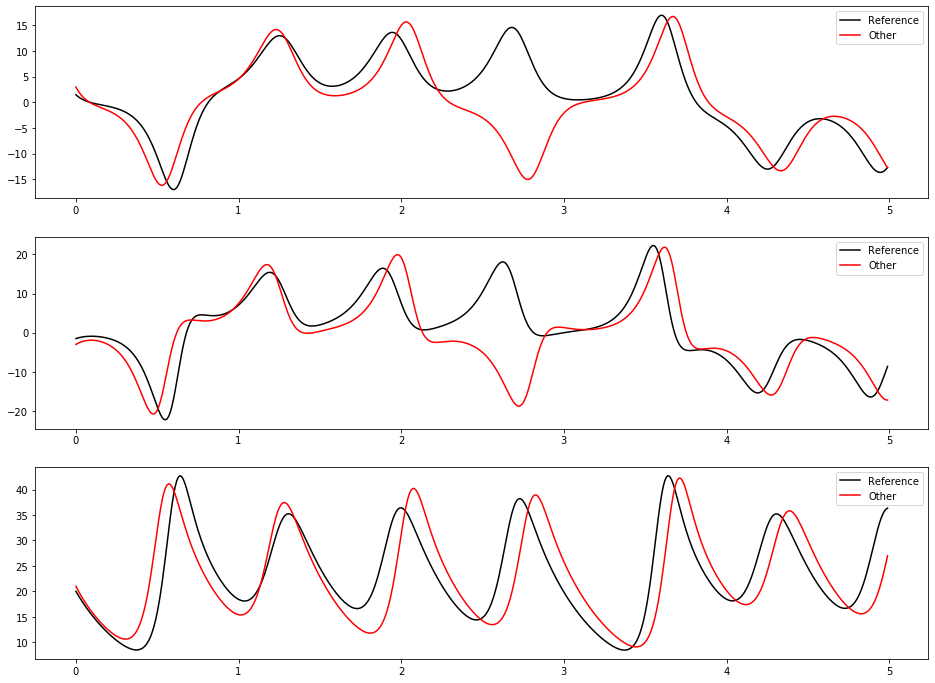

In [52]:
lorenz_test1 = Lorenz()
lorenz_test1.x0 = np.copy(wrong_state)
lorenz_test1.xvar = lorenz_test1.initial_condition() # Not sure why w call the initial condition...
lorenz_test1.forward(ntime)
plt.figure(figsize=(16,12))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.5,label='Reference')
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.5,label='Other')
    plt.legend()
plt.show()

## Creation of "observed" instances of variable x
We use the states from our Lorenz reference model as if they were the "observed" states. 
We only observe the state of variable x (This is hardcoded so it must be improved in the future). Only 4 states of x are observed (for now!).

In [116]:
# Real values for x (random pick)
obs_x = [true_state[0,25,0],true_state[0,125,0],true_state[0,225,0],true_state[0,325,0],true_state[0,425,0]]
# Corresponding time instance rounded to two decimals
obs_time = [true_time[25],true_time[125],true_time[225],true_time[325],true_time[425]]

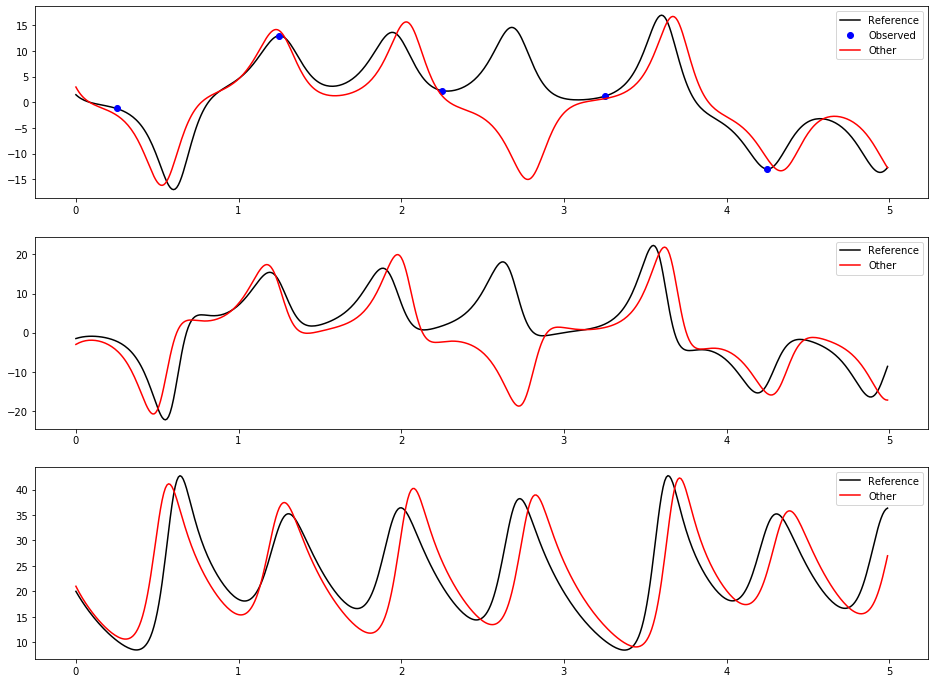

In [117]:
plt.figure(figsize=(16,12))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.5,label='Reference')
    if ix == 0:
        plt.plot(obs_time,obs_x,'bo',label='Observed')        
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.5,label='Other')
    plt.legend()
plt.show()

## Nudging the Lorenz63 model
We create another class that applies nudging to the Lorenz63 model based on the observed values for variable x. This class is defaulted to the same parameters and initial condition of the Lorenz reference model above. Thus, if run in default it will output the same as the reference model (it will nudge the model to its own values).

In [118]:
class Lorenz_Nudging():
    
    def __init__(self, nmembers = 1):
    
        self.nmembers = nmembers  # still don't understand what this is
        self.nx = 3         # number of variables

        # Parameters:
        self.sigma = 10
        self.rho = 28
        self.beta = 8./3.

        self.dt = 0.01 # timestep
        self.x0 = np.array([1.5, -1.5, 20.]) # Initial condition array
        self.xvar = self.initial_condition() # Reshapes our initial condition 
                                             # and does something else that I don't understand
        self.xvar_series = []  # This will be the array with the "solutions" (x,y,z) for each time step
        self.time = 0.         # Initial time count starts at zero
        self.time_series = []  # This will be the array with the time steps corresponding to the "solutions"
        
        # Parameters prescribed at call of forward function
        self.k_nudging = 0.           # Nudging coefficient needed for nudging term
        self.time_interval = 0.   # Needed for nudging
                  
    def initial_condition(self):
        """Define the initial condition"""
         
        if self.nmembers == 1:
            xout = self.x0.reshape((self.nx, 1)) #Reshapes x0
        else:
            p0 = 3.*np.eye(self.nx)                                             # what is this for? 
            xout = np.random.multivariate_normal(self.x0, p0, self.nmembers).T
              
        return xout # This is the reshaped initial condition[[x0],[y0],[z0]]
    
    def observation(self, obs_x, obs_time,time): #time is defined in the previous function "nudging_term" as self.time 
                                           # which is a float 
        """Check if an obs is available for this day and get value.
        """
        obs_time = np.around(obs_time,2)
        check = False      
        realtime = []
        realx = []
                
        for time_tmp in obs_time:
            
            if time in np.around(np.arange(time_tmp-self.time_interval*self.dt, time_tmp+self.time_interval*self.dt,self.dt),2): 
                # this is the range around the real time value. "around" rounds up to two decimal point since python 
                # does a weird thing and makes the range's floats with long precision. "arange" makes the range about 
                # the real time with floats
                check = True                
                realtime = realtime + [time_tmp]  # This makes a list of a single component
                io = int(np.where(obs_time == time_tmp)[0])
                realx = realx + [obs_x[io]]                         
      
        return check, realtime, realx
    
    def nudging_coefficient(self, time, realtime):
        """Compute the nudging coefficient K. K is a hat function taking values
        0 at time = realtime - or + day_interval, and self.k_nudging at time = realtime.
        ----------
        Parameters:
        ----------
        day: simulation day (integer of self.time)
        obs_day: day of observation
        -------
        Returns:
        -------
        nudging coefficient. 

        """
        
        a = realtime-time ## If obsday > day then a == positive vice-versa
        
        ## np.sign returns -1,0 or 1 depending on sign of a.
        
        a = 1. - np.sign(a)*a/np.float(self.time_interval) 
        
        a = np.maximum(a,0.) 
        
        return self.k_nudging*a
    
    def nudging_term(self, x_in):
        """Compute the nudging term using all eligible observations.
        """
    
        nudg_out = np.zeros_like(x_in)
    
        time = float(np.around(self.time,2)) #
    
        check_obs, real_time, real_x = self.observation(obs_x, obs_time,time)
    
        if check_obs == True:
        
            nobs = len(real_time) # not sure why we do this v
        
            for io in range(nobs):
            
                realtime = real_time[io]
                realx = real_x[io]
                nudg_out[0,] = nudg_out[0,] + self.nudging_coefficient(time,realtime)*(realx-self.xvar[0,])
            
        return nudg_out
    
    def rhs(self,x_in):
        """right hand side term of Lorenz 63. Gets a vector x,y,z and outputs a vector f(x,y,z)"""
        
        x_out = np.zeros_like(x_in)   # Creates array x_out of zeros with the shape of x_in
        x_out[0,] = self.sigma*(x_in[1,]-x_in[0,])               # Lorenz63 equation 1
        x_out[1,] = self.rho*x_in[0,]-x_in[1,]-x_in[0,]*x_in[2,] # Lorenz63 equation 2
        x_out[2,] = x_in[0,]*x_in[1,]-self.beta*x_in[2,]         # Lorenz63 equation 3
        
        return x_out
    
    def rhs_with_nudging(self, x_in):
        """return RHS term expanded with nudging term. This is meant to be argument of the rungekutta function."""
        return self.rhs(x_in) + self.nudging_term(x_in)
    
    def rk2(self, func_in): # This is computing rk2 called from forward
            ''' Computes with RK2. Input is rhs's x_out (for now) should be changed to RHS with nudging!'''
            k1 = self.rhs_with_nudging(self.xvar)*self.dt
            xtmp = self.xvar + k1 
            k2 = self.rhs_with_nudging(xtmp)*self.dt   
            self.xvar += 0.5*(k1 + k2)       

    def forward(self, nstep_in, k_nudging=0.5, time_interval=20):
        '''This is RK2 (Heun's method TO BE CHANGED) for Lorenz63'''
        
        self.k_nudging = k_nudging 
        self.time_interval = time_interval
        
        self.xvar_series = np.zeros((self.nx, nstep_in, self.nmembers))
        self.time_series = np.zeros(nstep_in)
        
        for it in range(nstep_in):
            self.xvar_series[:,it,:] = self.xvar   # Saves each solution vector to xvar_series to be plotted after
            self.time_series[it] = self.time       # Saves timestep respectively
            
            self.rk2(self.rhs_with_nudging) #RK2. Needs to be changed to rhs with nudging after that is done

            self.time += self.dt       
    
    
    
    def plot(self):
        plt.figure(figsize=(12,8))
        for ix in range(self.nx):
            pnum = str(311+ix)
            plt.subplot(pnum)
            for ie in range(self.nmembers):
                plt.plot(self.time_series[:],self.xvar_series[ix,:,ie],'black',linewidth=1.)
        plt.show()
    

## Running the model with nudging

 Now, we run lorenz_nudge with the following nudging parameters:

 1) Nudging coefficient: k_nudging = 0.4
 
 2) Time interval: time_interval = 150  (seems large but this is made in steps of 0.01)
 
 The above values were chosen by testing several combinations by hand. This combination yielded a "fair" result (especially in the beginning) but if the reference model was not known it would be difficult to know if the nudged result was anywhere near a good approximation of reality.

NOTE: We must also change the initial condition to the wrong state defined previously!

In [157]:
lorenz_nudge = Lorenz_Nudging()
lorenz_nudge.x0 = np.copy(wrong_state)
lorenz_nudge.xvar = lorenz_nudge.initial_condition()
lorenz_nudge.forward(ntime, k_nudging = 0.4, time_interval = 150)

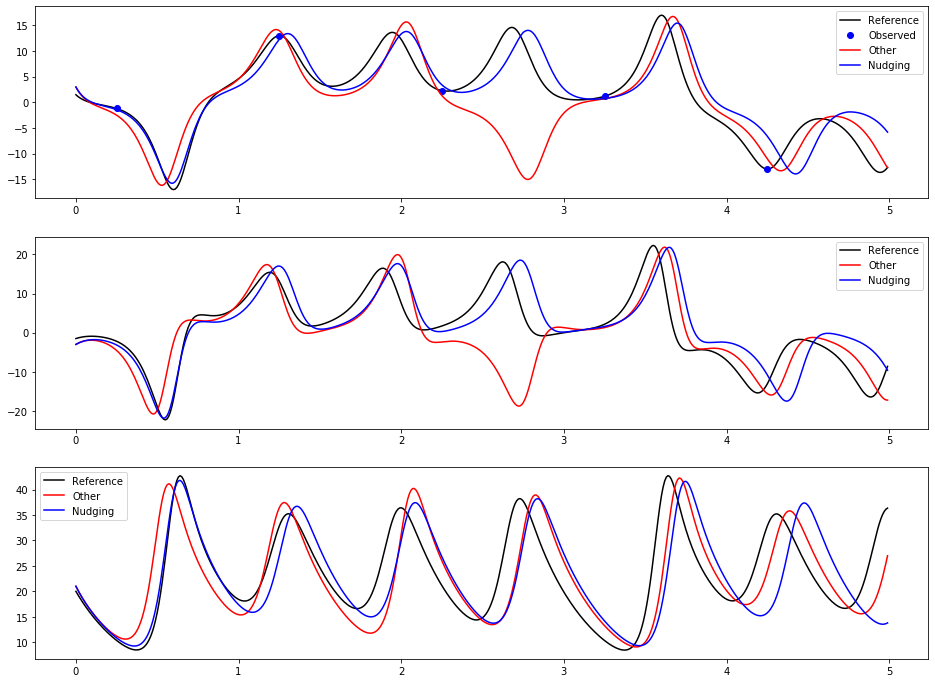

In [158]:
plt.figure(figsize=(16,12))
for ix in range(3):
    pnum = str(311+ix)
    plt.subplot(pnum)
    plt.plot(true_time,true_state[ix,:,0],'black',linewidth=1.5,label='Reference')
    if ix == 0:
        plt.plot(obs_time,obs_x,'bo',label='Observed')        
    plt.plot(lorenz_test1.time_series,lorenz_test1.xvar_series[ix,:,0],'red',linewidth=1.5,label='Other')
    plt.plot(lorenz_nudge.time_series,lorenz_nudge.xvar_series[ix,:,0],'blue',linewidth=1.5,label='Nudging')
    plt.legend()
plt.show()

## Discussion

This is a first attempt of implementing nudging in Lorenz63. Essentially, I used the same methodology of nudging found in the GeoChemNumerics notebook and implemented it on the Lorenz Model. Thus, the code is probably not optimal. Additionally, I used an RK2 method (Heun's Method) to solve the system because I found it easier to implement and I wanted to see if I could do it. Obviously, RK4 is a better way to go and it is very easy to change this in the code (will be done in future).

I am not very happy with this result given that if the reference model was not known I would have no idea if the nudging's output was a good approximation. Also, changing where the observations are taken greatly affects the result. And finally, changing the nudging coefficient and time interval will also greatly affect the result (expected).

## To be done:

- Implement RK4.
- Find a more optimal way of providing "observed" values.
- Change code in such a way that the observed values can be of x, y or z.
- (Maybe) Add a method to LorenzNudging() such that we can call a reference model from it without needing two classes.
- Implement nudging to a model with wrong initial condition AND wrong parameters.
- Probably study the error would be a good idea.